In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch

# GPU belleğini boşalt
torch.cuda.empty_cache()

# CUDA bellek tahsislerini sıfırla
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()


In [ ]:
import gc
import torch

# Tüm gereksiz değişkenleri temizle
gc.collect()
torch.cuda.empty_cache()


**lr=1-e5  32 batch size**

**lr=5e-5,**

**batch_size=16**



In [6]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, Wav2Vec2Config
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tqdm import tqdm
import pickle
import torch.nn.functional as F
import numpy as np
from google.colab import drive

# Google Drive'ı bağla
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, processor, target_length=160000):
        self.audio_paths = audio_paths
        self.labels = labels
        self.processor = processor
        self.target_length = target_length

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        file_path = self.audio_paths[idx]
        label = self.labels[idx]
        waveform, sr = torchaudio.load(file_path)
        waveform = waveform.squeeze()

        # Eğer ses uzunluğu `target_length`'den küçükse, padding ekle
        if waveform.size(0) < self.target_length:
            waveform = F.pad(waveform, (0, self.target_length - waveform.size(0)))
        else:
            waveform = waveform[:self.target_length]

        inputs = self.processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)
        return inputs.input_values[0], label

def load_data(base_dir, categories, notes):
    file_paths, labels = [], []
    label_map = {note: idx for idx, note in enumerate(notes)}

    for category in categories:
        for note in notes:
            path = os.path.join(base_dir, category, note)
            if not os.path.exists(path):
                print(f"Warning: {path} does not exist.")
                continue
            files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".wav")]
            file_paths.extend(files)
            labels.extend([label_map[note]] * len(files))
    return file_paths, labels

def collate_fn(batch):
    inputs = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True)
    return inputs_padded, torch.tensor(labels)

def train_model(train_loader, val_loader, model, processor, epochs=200, output_dir="model/wav2vec"):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    loss_fn = torch.nn.CrossEntropyLoss()
    model.to(device)

    global best_accuracy  # Global değişken olarak tanımla
    best_accuracy = 0  # En iyi doğruluk değerini sıfırla
    metrics_history = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_preds, train_targets = [], []
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs).logits
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                train_preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())
                train_targets.extend(labels.cpu().numpy())
                pbar.update(1)

        train_accuracy = accuracy_score(train_targets, train_preds)
        print(f"Epoch {epoch + 1}: Train Loss: {total_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        model.eval()
        total_val_loss = 0
        val_targets, val_preds = [], []
        val_probs = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).logits
                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                val_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

        val_accuracy = accuracy_score(val_targets, val_preds)
        precision = precision_score(val_targets, val_preds, average="weighted", zero_division=1)
        recall = recall_score(val_targets, val_preds, average="weighted", zero_division=1)
        f1 = f1_score(val_targets, val_preds, average="weighted", zero_division=1)

        # ROC ve AUC hesaplama
        val_probs_np = np.array(val_probs)
        fpr, tpr, _ = roc_curve(val_targets, val_probs_np[:, 1], pos_label=1)  # Binary sınıflandırma için
        roc_auc = auc(fpr, tpr)

        metrics = {
            "epoch": epoch + 1,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
            "train_loss": total_train_loss,
            "val_loss": total_val_loss,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "fpr": fpr.tolist(),
            "tpr": tpr.tolist(),
            "auc": roc_auc,
        }

        metrics_history.append(metrics)
        print(f"Epoch {epoch + 1}: Validation Accuracy: {val_accuracy:.4f}, F1 Score: {f1:.4f}, AUC: {roc_auc:.4f}")
        save_model_and_metrics(model, metrics_history, output_dir, val_accuracy)


def save_model_and_metrics(model, metrics_history, output_dir, accuracy):
    global best_accuracy
    model_output_dir = os.path.join(output_dir, "wav2vec")
    os.makedirs(model_output_dir, exist_ok=True)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), os.path.join(model_output_dir, "wav2vec_best.pt"))

    torch.save(model.state_dict(), os.path.join(model_output_dir, "wav2vec_last.pt"))

    with open(os.path.join(model_output_dir, "metrics.pkl"), "wb") as f:
        pickle.dump(metrics_history, f)

base_dir = "/content/drive/MyDrive/processed"

train_audio_paths, train_labels = load_data(os.path.join(base_dir, "train"), ["akortlu", "akortsuz"], ["Do", "Do#", "Re", "Re#", "Mi", "Fa", "Fa#", "Sol", "Sol#", "La", "La#", "Si"])
val_audio_paths, val_labels = load_data(os.path.join(base_dir, "val"), ["akortlu", "akortsuz"], ["Do", "Do#", "Re", "Re#", "Mi", "Fa", "Fa#", "Sol", "Sol#", "La", "La#", "Si"])

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
config = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-base", num_labels=12)

model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", config=config)

train_dataset = AudioDataset(train_audio_paths, train_labels, processor)
val_dataset = AudioDataset(val_audio_paths, val_labels, processor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

output_dir = "/content/drive/MyDrive/model"
train_model(train_loader, val_loader, model, processor, epochs=200, output_dir=output_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/200: 100%|██████████| 51/51 [01:10<00:00,  1.37s/it]


Epoch 1: Train Loss: 126.6567, Train Accuracy: 0.0949
Epoch 1: Validation Accuracy: 0.0885, F1 Score: 0.0436, AUC: 0.5150


Epoch 2/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 2: Train Loss: 124.7332, Train Accuracy: 0.1307
Epoch 2: Validation Accuracy: 0.1148, F1 Score: 0.0701, AUC: 0.6497


Epoch 3/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 3: Train Loss: 121.6244, Train Accuracy: 0.1517
Epoch 3: Validation Accuracy: 0.1675, F1 Score: 0.1096, AUC: 0.6373


Epoch 4/200: 100%|██████████| 51/51 [01:11<00:00,  1.39s/it]


Epoch 4: Train Loss: 114.8267, Train Accuracy: 0.1868
Epoch 4: Validation Accuracy: 0.1507, F1 Score: 0.0931, AUC: 0.6018


Epoch 5/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 5: Train Loss: 107.9123, Train Accuracy: 0.2164
Epoch 5: Validation Accuracy: 0.2081, F1 Score: 0.1596, AUC: 0.6484


Epoch 6/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 6: Train Loss: 99.1362, Train Accuracy: 0.2947
Epoch 6: Validation Accuracy: 0.2751, F1 Score: 0.2453, AUC: 0.6892


Epoch 7/200: 100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


Epoch 7: Train Loss: 91.9107, Train Accuracy: 0.3459
Epoch 7: Validation Accuracy: 0.2679, F1 Score: 0.2485, AUC: 0.7978


Epoch 8/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 8: Train Loss: 87.6317, Train Accuracy: 0.3607
Epoch 8: Validation Accuracy: 0.2990, F1 Score: 0.2848, AUC: 0.8390


Epoch 9/200: 100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


Epoch 9: Train Loss: 80.1973, Train Accuracy: 0.4297
Epoch 9: Validation Accuracy: 0.3780, F1 Score: 0.3715, AUC: 0.8836


Epoch 10/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 10: Train Loss: 74.8493, Train Accuracy: 0.4562
Epoch 10: Validation Accuracy: 0.3923, F1 Score: 0.3831, AUC: 0.9112


Epoch 11/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 11: Train Loss: 70.4240, Train Accuracy: 0.5000
Epoch 11: Validation Accuracy: 0.3517, F1 Score: 0.3461, AUC: 0.8938


Epoch 12/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 12: Train Loss: 66.1216, Train Accuracy: 0.5376
Epoch 12: Validation Accuracy: 0.3947, F1 Score: 0.3758, AUC: 0.9096


Epoch 13/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 13: Train Loss: 63.3810, Train Accuracy: 0.5499
Epoch 13: Validation Accuracy: 0.3900, F1 Score: 0.3875, AUC: 0.9062


Epoch 14/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 14: Train Loss: 59.5421, Train Accuracy: 0.5734
Epoch 14: Validation Accuracy: 0.4904, F1 Score: 0.4829, AUC: 0.9092


Epoch 15/200: 100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


Epoch 15: Train Loss: 55.2729, Train Accuracy: 0.6381
Epoch 15: Validation Accuracy: 0.4641, F1 Score: 0.4610, AUC: 0.9338


Epoch 16/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 16: Train Loss: 51.6915, Train Accuracy: 0.6831
Epoch 16: Validation Accuracy: 0.5072, F1 Score: 0.5006, AUC: 0.9257


Epoch 17/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 17: Train Loss: 53.2312, Train Accuracy: 0.6356
Epoch 17: Validation Accuracy: 0.3876, F1 Score: 0.3833, AUC: 0.8549


Epoch 18/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 18: Train Loss: 53.7809, Train Accuracy: 0.6060
Epoch 18: Validation Accuracy: 0.4306, F1 Score: 0.4248, AUC: 0.9182


Epoch 19/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 19: Train Loss: 45.2103, Train Accuracy: 0.7324
Epoch 19: Validation Accuracy: 0.4761, F1 Score: 0.4731, AUC: 0.9329


Epoch 20/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 20: Train Loss: 43.9200, Train Accuracy: 0.7195
Epoch 20: Validation Accuracy: 0.5048, F1 Score: 0.5042, AUC: 0.9253


Epoch 21/200: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it]


Epoch 21: Train Loss: 39.7571, Train Accuracy: 0.7676
Epoch 21: Validation Accuracy: 0.5335, F1 Score: 0.5342, AUC: 0.9237


Epoch 22/200: 100%|██████████| 51/51 [01:12<00:00,  1.41s/it]


Epoch 22: Train Loss: 37.0163, Train Accuracy: 0.8027
Epoch 22: Validation Accuracy: 0.5239, F1 Score: 0.5204, AUC: 0.9358


Epoch 23/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 23: Train Loss: 33.0251, Train Accuracy: 0.8342
Epoch 23: Validation Accuracy: 0.5311, F1 Score: 0.5290, AUC: 0.9311


Epoch 24/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 24: Train Loss: 33.1030, Train Accuracy: 0.8101
Epoch 24: Validation Accuracy: 0.5120, F1 Score: 0.5115, AUC: 0.9124


Epoch 25/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 25: Train Loss: 30.2037, Train Accuracy: 0.8391
Epoch 25: Validation Accuracy: 0.5478, F1 Score: 0.5442, AUC: 0.9395


Epoch 26/200: 100%|██████████| 51/51 [01:13<00:00,  1.45s/it]


Epoch 26: Train Loss: 29.4213, Train Accuracy: 0.8459
Epoch 26: Validation Accuracy: 0.5622, F1 Score: 0.5626, AUC: 0.9359


Epoch 27/200: 100%|██████████| 51/51 [01:12<00:00,  1.41s/it]


Epoch 27: Train Loss: 26.3119, Train Accuracy: 0.8835
Epoch 27: Validation Accuracy: 0.5311, F1 Score: 0.5255, AUC: 0.9339


Epoch 28/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 28: Train Loss: 23.3050, Train Accuracy: 0.8915
Epoch 28: Validation Accuracy: 0.5431, F1 Score: 0.5420, AUC: 0.9301


Epoch 29/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 29: Train Loss: 25.1950, Train Accuracy: 0.8631
Epoch 29: Validation Accuracy: 0.5383, F1 Score: 0.5277, AUC: 0.9413


Epoch 30/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 30: Train Loss: 22.7840, Train Accuracy: 0.8903
Epoch 30: Validation Accuracy: 0.5335, F1 Score: 0.5316, AUC: 0.9188


Epoch 31/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 31: Train Loss: 19.1387, Train Accuracy: 0.9229
Epoch 31: Validation Accuracy: 0.5981, F1 Score: 0.5967, AUC: 0.9151


Epoch 32/200: 100%|██████████| 51/51 [01:13<00:00,  1.45s/it]


Epoch 32: Train Loss: 21.2987, Train Accuracy: 0.8829
Epoch 32: Validation Accuracy: 0.6364, F1 Score: 0.6307, AUC: 0.9296


Epoch 33/200: 100%|██████████| 51/51 [01:13<00:00,  1.45s/it]


Epoch 33: Train Loss: 18.6710, Train Accuracy: 0.8964
Epoch 33: Validation Accuracy: 0.6196, F1 Score: 0.6246, AUC: 0.9446


Epoch 34/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 34: Train Loss: 18.5103, Train Accuracy: 0.9044
Epoch 34: Validation Accuracy: 0.5694, F1 Score: 0.5669, AUC: 0.9410


Epoch 35/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 35: Train Loss: 20.1512, Train Accuracy: 0.8829
Epoch 35: Validation Accuracy: 0.6220, F1 Score: 0.6258, AUC: 0.9362


Epoch 36/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 36: Train Loss: 15.2531, Train Accuracy: 0.9273
Epoch 36: Validation Accuracy: 0.6411, F1 Score: 0.6428, AUC: 0.9369


Epoch 37/200: 100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


Epoch 37: Train Loss: 15.6669, Train Accuracy: 0.9131
Epoch 37: Validation Accuracy: 0.5144, F1 Score: 0.5039, AUC: 0.9365


Epoch 38/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 38: Train Loss: 17.1312, Train Accuracy: 0.9007
Epoch 38: Validation Accuracy: 0.6411, F1 Score: 0.6421, AUC: 0.9437


Epoch 39/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 39: Train Loss: 13.7315, Train Accuracy: 0.9334
Epoch 39: Validation Accuracy: 0.5239, F1 Score: 0.5186, AUC: 0.9499


Epoch 40/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 40: Train Loss: 14.0783, Train Accuracy: 0.9266
Epoch 40: Validation Accuracy: 0.6053, F1 Score: 0.6020, AUC: 0.9506


Epoch 41/200: 100%|██████████| 51/51 [01:11<00:00,  1.39s/it]


Epoch 41: Train Loss: 13.1594, Train Accuracy: 0.9303
Epoch 41: Validation Accuracy: 0.5813, F1 Score: 0.5755, AUC: 0.9427


Epoch 42/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 42: Train Loss: 10.5278, Train Accuracy: 0.9501
Epoch 42: Validation Accuracy: 0.6411, F1 Score: 0.6413, AUC: 0.9393


Epoch 43/200: 100%|██████████| 51/51 [01:12<00:00,  1.41s/it]


Epoch 43: Train Loss: 12.2801, Train Accuracy: 0.9303
Epoch 43: Validation Accuracy: 0.6459, F1 Score: 0.6461, AUC: 0.9584


Epoch 44/200: 100%|██████████| 51/51 [01:13<00:00,  1.43s/it]


Epoch 44: Train Loss: 10.8698, Train Accuracy: 0.9451
Epoch 44: Validation Accuracy: 0.5694, F1 Score: 0.5648, AUC: 0.9539


Epoch 45/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 45: Train Loss: 10.5104, Train Accuracy: 0.9488
Epoch 45: Validation Accuracy: 0.6124, F1 Score: 0.6108, AUC: 0.9368


Epoch 46/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 46: Train Loss: 12.2054, Train Accuracy: 0.9273
Epoch 46: Validation Accuracy: 0.5478, F1 Score: 0.5401, AUC: 0.9627


Epoch 47/200: 100%|██████████| 51/51 [01:12<00:00,  1.41s/it]


Epoch 47: Train Loss: 12.9105, Train Accuracy: 0.9266
Epoch 47: Validation Accuracy: 0.6148, F1 Score: 0.6131, AUC: 0.9432


Epoch 48/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 48: Train Loss: 11.5185, Train Accuracy: 0.9390
Epoch 48: Validation Accuracy: 0.6435, F1 Score: 0.6415, AUC: 0.9555


Epoch 49/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 49: Train Loss: 9.6662, Train Accuracy: 0.9420
Epoch 49: Validation Accuracy: 0.6172, F1 Score: 0.6160, AUC: 0.9723


Epoch 50/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 50: Train Loss: 8.3084, Train Accuracy: 0.9531
Epoch 50: Validation Accuracy: 0.6005, F1 Score: 0.5988, AUC: 0.9551


Epoch 51/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 51: Train Loss: 8.3632, Train Accuracy: 0.9575
Epoch 51: Validation Accuracy: 0.7153, F1 Score: 0.7117, AUC: 0.9466


Epoch 52/200: 100%|██████████| 51/51 [01:13<00:00,  1.43s/it]


Epoch 52: Train Loss: 10.1869, Train Accuracy: 0.9420
Epoch 52: Validation Accuracy: 0.5694, F1 Score: 0.5668, AUC: 0.9579


Epoch 53/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 53: Train Loss: 13.2413, Train Accuracy: 0.9248
Epoch 53: Validation Accuracy: 0.6603, F1 Score: 0.6565, AUC: 0.9633


Epoch 54/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 54: Train Loss: 6.8908, Train Accuracy: 0.9686
Epoch 54: Validation Accuracy: 0.6411, F1 Score: 0.6409, AUC: 0.9512


Epoch 55/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 55: Train Loss: 7.2148, Train Accuracy: 0.9661
Epoch 55: Validation Accuracy: 0.7081, F1 Score: 0.7083, AUC: 0.9560


Epoch 56/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 56: Train Loss: 6.7311, Train Accuracy: 0.9710
Epoch 56: Validation Accuracy: 0.7129, F1 Score: 0.7109, AUC: 0.9429


Epoch 57/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 57: Train Loss: 9.0231, Train Accuracy: 0.9451
Epoch 57: Validation Accuracy: 0.7249, F1 Score: 0.7222, AUC: 0.9449


Epoch 58/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 58: Train Loss: 9.9322, Train Accuracy: 0.9408
Epoch 58: Validation Accuracy: 0.7225, F1 Score: 0.7188, AUC: 0.9482


Epoch 59/200: 100%|██████████| 51/51 [01:12<00:00,  1.41s/it]


Epoch 59: Train Loss: 8.2289, Train Accuracy: 0.9544
Epoch 59: Validation Accuracy: 0.6651, F1 Score: 0.6589, AUC: 0.9643


Epoch 60/200: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it]


Epoch 60: Train Loss: 5.3338, Train Accuracy: 0.9741
Epoch 60: Validation Accuracy: 0.7033, F1 Score: 0.7040, AUC: 0.9637


Epoch 61/200: 100%|██████████| 51/51 [01:11<00:00,  1.39s/it]


Epoch 61: Train Loss: 8.6905, Train Accuracy: 0.9531
Epoch 61: Validation Accuracy: 0.6866, F1 Score: 0.6863, AUC: 0.9526


Epoch 62/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 62: Train Loss: 15.6494, Train Accuracy: 0.9014
Epoch 62: Validation Accuracy: 0.6148, F1 Score: 0.6107, AUC: 0.9583


Epoch 63/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 63: Train Loss: 8.2046, Train Accuracy: 0.9562
Epoch 63: Validation Accuracy: 0.6866, F1 Score: 0.6831, AUC: 0.9609


Epoch 64/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 64: Train Loss: 7.9548, Train Accuracy: 0.9605
Epoch 64: Validation Accuracy: 0.7010, F1 Score: 0.6991, AUC: 0.9524


Epoch 65/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 65: Train Loss: 6.5586, Train Accuracy: 0.9679
Epoch 65: Validation Accuracy: 0.6435, F1 Score: 0.6437, AUC: 0.9426


Epoch 66/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 66: Train Loss: 8.4137, Train Accuracy: 0.9476
Epoch 66: Validation Accuracy: 0.6962, F1 Score: 0.6927, AUC: 0.9502


Epoch 67/200: 100%|██████████| 51/51 [01:12<00:00,  1.41s/it]


Epoch 67: Train Loss: 9.6549, Train Accuracy: 0.9464
Epoch 67: Validation Accuracy: 0.6962, F1 Score: 0.6930, AUC: 0.9588


Epoch 68/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 68: Train Loss: 8.6409, Train Accuracy: 0.9507
Epoch 68: Validation Accuracy: 0.6316, F1 Score: 0.6303, AUC: 0.9555


Epoch 69/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 69: Train Loss: 5.3827, Train Accuracy: 0.9698
Epoch 69: Validation Accuracy: 0.7273, F1 Score: 0.7283, AUC: 0.9564


Epoch 70/200: 100%|██████████| 51/51 [01:13<00:00,  1.43s/it]


Epoch 70: Train Loss: 4.0139, Train Accuracy: 0.9790
Epoch 70: Validation Accuracy: 0.7225, F1 Score: 0.7228, AUC: 0.9678


Epoch 71/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 71: Train Loss: 5.0976, Train Accuracy: 0.9741
Epoch 71: Validation Accuracy: 0.6172, F1 Score: 0.6180, AUC: 0.9454


Epoch 72/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 72: Train Loss: 9.1700, Train Accuracy: 0.9525
Epoch 72: Validation Accuracy: 0.7105, F1 Score: 0.7108, AUC: 0.9621


Epoch 73/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 73: Train Loss: 7.5980, Train Accuracy: 0.9525
Epoch 73: Validation Accuracy: 0.6172, F1 Score: 0.6111, AUC: 0.9517


Epoch 74/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 74: Train Loss: 4.7559, Train Accuracy: 0.9772
Epoch 74: Validation Accuracy: 0.7297, F1 Score: 0.7291, AUC: 0.9602


Epoch 75/200: 100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


Epoch 75: Train Loss: 4.2876, Train Accuracy: 0.9766
Epoch 75: Validation Accuracy: 0.6722, F1 Score: 0.6723, AUC: 0.9548


Epoch 76/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 76: Train Loss: 8.7754, Train Accuracy: 0.9414
Epoch 76: Validation Accuracy: 0.6746, F1 Score: 0.6727, AUC: 0.9683


Epoch 77/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 77: Train Loss: 8.0821, Train Accuracy: 0.9519
Epoch 77: Validation Accuracy: 0.6962, F1 Score: 0.6959, AUC: 0.9630


Epoch 78/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 78: Train Loss: 5.6708, Train Accuracy: 0.9642
Epoch 78: Validation Accuracy: 0.6842, F1 Score: 0.6833, AUC: 0.9608


Epoch 79/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 79: Train Loss: 6.3830, Train Accuracy: 0.9686
Epoch 79: Validation Accuracy: 0.7225, F1 Score: 0.7224, AUC: 0.9466


Epoch 80/200: 100%|██████████| 51/51 [01:09<00:00,  1.37s/it]


Epoch 80: Train Loss: 5.2930, Train Accuracy: 0.9716
Epoch 80: Validation Accuracy: 0.6890, F1 Score: 0.6876, AUC: 0.9637


Epoch 81/200: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it]


Epoch 81: Train Loss: 4.9581, Train Accuracy: 0.9760
Epoch 81: Validation Accuracy: 0.6411, F1 Score: 0.6378, AUC: 0.9508


Epoch 82/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 82: Train Loss: 4.1786, Train Accuracy: 0.9766
Epoch 82: Validation Accuracy: 0.7440, F1 Score: 0.7448, AUC: 0.9621


Epoch 83/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 83: Train Loss: 4.9455, Train Accuracy: 0.9741
Epoch 83: Validation Accuracy: 0.7273, F1 Score: 0.7257, AUC: 0.9613


Epoch 84/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 84: Train Loss: 4.5835, Train Accuracy: 0.9760
Epoch 84: Validation Accuracy: 0.6914, F1 Score: 0.6900, AUC: 0.9715


Epoch 85/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 85: Train Loss: 5.7149, Train Accuracy: 0.9710
Epoch 85: Validation Accuracy: 0.6866, F1 Score: 0.6897, AUC: 0.9662


Epoch 86/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 86: Train Loss: 3.6696, Train Accuracy: 0.9827
Epoch 86: Validation Accuracy: 0.6938, F1 Score: 0.6946, AUC: 0.9591


Epoch 87/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 87: Train Loss: 2.4725, Train Accuracy: 0.9895
Epoch 87: Validation Accuracy: 0.7249, F1 Score: 0.7241, AUC: 0.9544


Epoch 88/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 88: Train Loss: 2.3829, Train Accuracy: 0.9938
Epoch 88: Validation Accuracy: 0.7823, F1 Score: 0.7815, AUC: 0.9578


Epoch 89/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 89: Train Loss: 2.8802, Train Accuracy: 0.9871
Epoch 89: Validation Accuracy: 0.7177, F1 Score: 0.7179, AUC: 0.9651


Epoch 90/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 90: Train Loss: 4.0854, Train Accuracy: 0.9741
Epoch 90: Validation Accuracy: 0.7177, F1 Score: 0.7167, AUC: 0.9655


Epoch 91/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 91: Train Loss: 5.5359, Train Accuracy: 0.9686
Epoch 91: Validation Accuracy: 0.6866, F1 Score: 0.6808, AUC: 0.9561


Epoch 92/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 92: Train Loss: 6.4317, Train Accuracy: 0.9605
Epoch 92: Validation Accuracy: 0.6483, F1 Score: 0.6463, AUC: 0.9533


Epoch 93/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 93: Train Loss: 9.0441, Train Accuracy: 0.9433
Epoch 93: Validation Accuracy: 0.7392, F1 Score: 0.7387, AUC: 0.9613


Epoch 94/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 94: Train Loss: 5.5804, Train Accuracy: 0.9698
Epoch 94: Validation Accuracy: 0.7488, F1 Score: 0.7497, AUC: 0.9500


Epoch 95/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 95: Train Loss: 3.4883, Train Accuracy: 0.9797
Epoch 95: Validation Accuracy: 0.7608, F1 Score: 0.7583, AUC: 0.9411


Epoch 96/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 96: Train Loss: 3.0552, Train Accuracy: 0.9846
Epoch 96: Validation Accuracy: 0.7536, F1 Score: 0.7548, AUC: 0.9634


Epoch 97/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 97: Train Loss: 5.4099, Train Accuracy: 0.9667
Epoch 97: Validation Accuracy: 0.7105, F1 Score: 0.7054, AUC: 0.9394


Epoch 98/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 98: Train Loss: 10.6685, Train Accuracy: 0.9340
Epoch 98: Validation Accuracy: 0.7368, F1 Score: 0.7337, AUC: 0.9547


Epoch 99/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 99: Train Loss: 8.5720, Train Accuracy: 0.9488
Epoch 99: Validation Accuracy: 0.7297, F1 Score: 0.7273, AUC: 0.9586


Epoch 100/200: 100%|██████████| 51/51 [01:11<00:00,  1.39s/it]


Epoch 100: Train Loss: 4.3409, Train Accuracy: 0.9809
Epoch 100: Validation Accuracy: 0.7895, F1 Score: 0.7887, AUC: 0.9678


Epoch 101/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 101: Train Loss: 2.3819, Train Accuracy: 0.9877
Epoch 101: Validation Accuracy: 0.7847, F1 Score: 0.7834, AUC: 0.9692


Epoch 102/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 102: Train Loss: 3.4907, Train Accuracy: 0.9784
Epoch 102: Validation Accuracy: 0.7679, F1 Score: 0.7668, AUC: 0.9636


Epoch 103/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 103: Train Loss: 3.7571, Train Accuracy: 0.9766
Epoch 103: Validation Accuracy: 0.7679, F1 Score: 0.7668, AUC: 0.9407


Epoch 104/200: 100%|██████████| 51/51 [01:12<00:00,  1.41s/it]


Epoch 104: Train Loss: 2.9197, Train Accuracy: 0.9834
Epoch 104: Validation Accuracy: 0.7919, F1 Score: 0.7915, AUC: 0.9619


Epoch 105/200: 100%|██████████| 51/51 [01:13<00:00,  1.45s/it]


Epoch 105: Train Loss: 1.7144, Train Accuracy: 0.9932
Epoch 105: Validation Accuracy: 0.7703, F1 Score: 0.7722, AUC: 0.9642


Epoch 106/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 106: Train Loss: 1.3414, Train Accuracy: 0.9945
Epoch 106: Validation Accuracy: 0.8014, F1 Score: 0.8005, AUC: 0.9592


Epoch 107/200: 100%|██████████| 51/51 [01:13<00:00,  1.45s/it]


Epoch 107: Train Loss: 1.8078, Train Accuracy: 0.9920
Epoch 107: Validation Accuracy: 0.7919, F1 Score: 0.7913, AUC: 0.9513


Epoch 108/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 108: Train Loss: 1.7868, Train Accuracy: 0.9914
Epoch 108: Validation Accuracy: 0.7033, F1 Score: 0.7045, AUC: 0.9641


Epoch 109/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 109: Train Loss: 1.3968, Train Accuracy: 0.9951
Epoch 109: Validation Accuracy: 0.6842, F1 Score: 0.6819, AUC: 0.9581


Epoch 110/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 110: Train Loss: 2.9598, Train Accuracy: 0.9846
Epoch 110: Validation Accuracy: 0.7871, F1 Score: 0.7851, AUC: 0.9404


Epoch 111/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 111: Train Loss: 6.3736, Train Accuracy: 0.9667
Epoch 111: Validation Accuracy: 0.7751, F1 Score: 0.7751, AUC: 0.9639


Epoch 112/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 112: Train Loss: 6.0296, Train Accuracy: 0.9649
Epoch 112: Validation Accuracy: 0.6770, F1 Score: 0.6768, AUC: 0.9594


Epoch 113/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 113: Train Loss: 7.3879, Train Accuracy: 0.9599
Epoch 113: Validation Accuracy: 0.7368, F1 Score: 0.7357, AUC: 0.9726


Epoch 114/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 114: Train Loss: 6.2708, Train Accuracy: 0.9562
Epoch 114: Validation Accuracy: 0.6794, F1 Score: 0.6798, AUC: 0.9709


Epoch 115/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 115: Train Loss: 4.1665, Train Accuracy: 0.9747
Epoch 115: Validation Accuracy: 0.7105, F1 Score: 0.7111, AUC: 0.9798


Epoch 116/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 116: Train Loss: 4.4975, Train Accuracy: 0.9716
Epoch 116: Validation Accuracy: 0.7512, F1 Score: 0.7494, AUC: 0.9819


Epoch 117/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 117: Train Loss: 2.4418, Train Accuracy: 0.9877
Epoch 117: Validation Accuracy: 0.7273, F1 Score: 0.7265, AUC: 0.9703


Epoch 118/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 118: Train Loss: 3.5622, Train Accuracy: 0.9797
Epoch 118: Validation Accuracy: 0.7153, F1 Score: 0.7118, AUC: 0.9500


Epoch 119/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 119: Train Loss: 6.4334, Train Accuracy: 0.9624
Epoch 119: Validation Accuracy: 0.7751, F1 Score: 0.7757, AUC: 0.9851


Epoch 120/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 120: Train Loss: 4.8222, Train Accuracy: 0.9710
Epoch 120: Validation Accuracy: 0.7775, F1 Score: 0.7760, AUC: 0.9832


Epoch 121/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 121: Train Loss: 2.9256, Train Accuracy: 0.9883
Epoch 121: Validation Accuracy: 0.7990, F1 Score: 0.7989, AUC: 0.9876


Epoch 122/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 122: Train Loss: 1.6945, Train Accuracy: 0.9914
Epoch 122: Validation Accuracy: 0.7321, F1 Score: 0.7315, AUC: 0.9801


Epoch 123/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 123: Train Loss: 2.8081, Train Accuracy: 0.9846
Epoch 123: Validation Accuracy: 0.8110, F1 Score: 0.8123, AUC: 0.9853


Epoch 124/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 124: Train Loss: 2.9939, Train Accuracy: 0.9846
Epoch 124: Validation Accuracy: 0.7871, F1 Score: 0.7868, AUC: 0.9822


Epoch 125/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 125: Train Loss: 3.8385, Train Accuracy: 0.9772
Epoch 125: Validation Accuracy: 0.7967, F1 Score: 0.7957, AUC: 0.9852


Epoch 126/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 126: Train Loss: 2.3599, Train Accuracy: 0.9877
Epoch 126: Validation Accuracy: 0.8086, F1 Score: 0.8088, AUC: 0.9707


Epoch 127/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 127: Train Loss: 1.3263, Train Accuracy: 0.9938
Epoch 127: Validation Accuracy: 0.8445, F1 Score: 0.8448, AUC: 0.9785


Epoch 128/200: 100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


Epoch 128: Train Loss: 1.3357, Train Accuracy: 0.9945
Epoch 128: Validation Accuracy: 0.8206, F1 Score: 0.8188, AUC: 0.9666


Epoch 129/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 129: Train Loss: 0.8320, Train Accuracy: 0.9975
Epoch 129: Validation Accuracy: 0.8062, F1 Score: 0.8047, AUC: 0.9807


Epoch 130/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 130: Train Loss: 3.1941, Train Accuracy: 0.9827
Epoch 130: Validation Accuracy: 0.7273, F1 Score: 0.7237, AUC: 0.9787


Epoch 131/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 131: Train Loss: 6.0715, Train Accuracy: 0.9704
Epoch 131: Validation Accuracy: 0.7847, F1 Score: 0.7838, AUC: 0.9751


Epoch 132/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 132: Train Loss: 7.0960, Train Accuracy: 0.9649
Epoch 132: Validation Accuracy: 0.7440, F1 Score: 0.7432, AUC: 0.9661


Epoch 133/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 133: Train Loss: 5.5116, Train Accuracy: 0.9692
Epoch 133: Validation Accuracy: 0.7727, F1 Score: 0.7720, AUC: 0.9826


Epoch 134/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 134: Train Loss: 3.7155, Train Accuracy: 0.9784
Epoch 134: Validation Accuracy: 0.7871, F1 Score: 0.7878, AUC: 0.9709


Epoch 135/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 135: Train Loss: 3.7475, Train Accuracy: 0.9766
Epoch 135: Validation Accuracy: 0.7823, F1 Score: 0.7827, AUC: 0.9739


Epoch 136/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 136: Train Loss: 2.1140, Train Accuracy: 0.9901
Epoch 136: Validation Accuracy: 0.7201, F1 Score: 0.7211, AUC: 0.9651


Epoch 137/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 137: Train Loss: 3.4707, Train Accuracy: 0.9815
Epoch 137: Validation Accuracy: 0.7871, F1 Score: 0.7861, AUC: 0.9756


Epoch 138/200: 100%|██████████| 51/51 [01:12<00:00,  1.41s/it]


Epoch 138: Train Loss: 3.6562, Train Accuracy: 0.9834
Epoch 138: Validation Accuracy: 0.6986, F1 Score: 0.6992, AUC: 0.9711


Epoch 139/200: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it]


Epoch 139: Train Loss: 4.1272, Train Accuracy: 0.9803
Epoch 139: Validation Accuracy: 0.7536, F1 Score: 0.7484, AUC: 0.9725


Epoch 140/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 140: Train Loss: 4.6508, Train Accuracy: 0.9760
Epoch 140: Validation Accuracy: 0.7919, F1 Score: 0.7895, AUC: 0.9771


Epoch 141/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 141: Train Loss: 3.0719, Train Accuracy: 0.9840
Epoch 141: Validation Accuracy: 0.7632, F1 Score: 0.7615, AUC: 0.9688


Epoch 142/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 142: Train Loss: 1.5675, Train Accuracy: 0.9920
Epoch 142: Validation Accuracy: 0.7895, F1 Score: 0.7878, AUC: 0.9769


Epoch 143/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 143: Train Loss: 3.2374, Train Accuracy: 0.9803
Epoch 143: Validation Accuracy: 0.7440, F1 Score: 0.7428, AUC: 0.9595


Epoch 144/200: 100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


Epoch 144: Train Loss: 10.8556, Train Accuracy: 0.9377
Epoch 144: Validation Accuracy: 0.6842, F1 Score: 0.6779, AUC: 0.9586


Epoch 145/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 145: Train Loss: 5.9230, Train Accuracy: 0.9673
Epoch 145: Validation Accuracy: 0.7775, F1 Score: 0.7776, AUC: 0.9653


Epoch 146/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 146: Train Loss: 3.4356, Train Accuracy: 0.9797
Epoch 146: Validation Accuracy: 0.8254, F1 Score: 0.8255, AUC: 0.9747


Epoch 147/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 147: Train Loss: 3.2105, Train Accuracy: 0.9834
Epoch 147: Validation Accuracy: 0.8206, F1 Score: 0.8208, AUC: 0.9809


Epoch 148/200: 100%|██████████| 51/51 [01:12<00:00,  1.41s/it]


Epoch 148: Train Loss: 2.0520, Train Accuracy: 0.9914
Epoch 148: Validation Accuracy: 0.7536, F1 Score: 0.7543, AUC: 0.9743


Epoch 149/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 149: Train Loss: 2.1264, Train Accuracy: 0.9901
Epoch 149: Validation Accuracy: 0.8182, F1 Score: 0.8176, AUC: 0.9778


Epoch 150/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 150: Train Loss: 0.6533, Train Accuracy: 0.9988
Epoch 150: Validation Accuracy: 0.8397, F1 Score: 0.8396, AUC: 0.9789


Epoch 151/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 151: Train Loss: 0.5955, Train Accuracy: 0.9975
Epoch 151: Validation Accuracy: 0.8325, F1 Score: 0.8318, AUC: 0.9747


Epoch 152/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 152: Train Loss: 0.5642, Train Accuracy: 0.9994
Epoch 152: Validation Accuracy: 0.8278, F1 Score: 0.8272, AUC: 0.9807


Epoch 153/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 153: Train Loss: 0.2898, Train Accuracy: 1.0000
Epoch 153: Validation Accuracy: 0.8301, F1 Score: 0.8296, AUC: 0.9792


Epoch 154/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 154: Train Loss: 0.2811, Train Accuracy: 1.0000
Epoch 154: Validation Accuracy: 0.8301, F1 Score: 0.8295, AUC: 0.9790


Epoch 155/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 155: Train Loss: 0.2692, Train Accuracy: 1.0000
Epoch 155: Validation Accuracy: 0.8373, F1 Score: 0.8366, AUC: 0.9782


Epoch 156/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 156: Train Loss: 0.2558, Train Accuracy: 1.0000
Epoch 156: Validation Accuracy: 0.8373, F1 Score: 0.8369, AUC: 0.9790


Epoch 157/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 157: Train Loss: 0.2462, Train Accuracy: 1.0000
Epoch 157: Validation Accuracy: 0.8373, F1 Score: 0.8369, AUC: 0.9786


Epoch 158/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 158: Train Loss: 0.2365, Train Accuracy: 1.0000
Epoch 158: Validation Accuracy: 0.8445, F1 Score: 0.8440, AUC: 0.9785


Epoch 159/200: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it]


Epoch 159: Train Loss: 0.2305, Train Accuracy: 1.0000
Epoch 159: Validation Accuracy: 0.8445, F1 Score: 0.8440, AUC: 0.9783


Epoch 160/200: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it]


Epoch 160: Train Loss: 0.2243, Train Accuracy: 1.0000
Epoch 160: Validation Accuracy: 0.8421, F1 Score: 0.8417, AUC: 0.9782


Epoch 161/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 161: Train Loss: 0.2290, Train Accuracy: 1.0000
Epoch 161: Validation Accuracy: 0.8469, F1 Score: 0.8464, AUC: 0.9792


Epoch 162/200: 100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


Epoch 162: Train Loss: 0.2121, Train Accuracy: 1.0000
Epoch 162: Validation Accuracy: 0.8469, F1 Score: 0.8465, AUC: 0.9788


Epoch 163/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 163: Train Loss: 0.2073, Train Accuracy: 1.0000
Epoch 163: Validation Accuracy: 0.8517, F1 Score: 0.8517, AUC: 0.9791


Epoch 164/200: 100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


Epoch 164: Train Loss: 0.2011, Train Accuracy: 1.0000
Epoch 164: Validation Accuracy: 0.8421, F1 Score: 0.8416, AUC: 0.9793


Epoch 165/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 165: Train Loss: 0.1956, Train Accuracy: 1.0000
Epoch 165: Validation Accuracy: 0.8373, F1 Score: 0.8368, AUC: 0.9794


Epoch 166/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 166: Train Loss: 0.1894, Train Accuracy: 1.0000
Epoch 166: Validation Accuracy: 0.8397, F1 Score: 0.8392, AUC: 0.9794


Epoch 167/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 167: Train Loss: 0.1840, Train Accuracy: 1.0000
Epoch 167: Validation Accuracy: 0.8421, F1 Score: 0.8416, AUC: 0.9788


Epoch 168/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 168: Train Loss: 0.1808, Train Accuracy: 1.0000
Epoch 168: Validation Accuracy: 0.8373, F1 Score: 0.8368, AUC: 0.9787


Epoch 169/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 169: Train Loss: 0.1744, Train Accuracy: 1.0000
Epoch 169: Validation Accuracy: 0.8397, F1 Score: 0.8391, AUC: 0.9783


Epoch 170/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 170: Train Loss: 0.1701, Train Accuracy: 1.0000
Epoch 170: Validation Accuracy: 0.8373, F1 Score: 0.8369, AUC: 0.9785


Epoch 171/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 171: Train Loss: 0.1661, Train Accuracy: 1.0000
Epoch 171: Validation Accuracy: 0.8373, F1 Score: 0.8369, AUC: 0.9781


Epoch 172/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 172: Train Loss: 0.1618, Train Accuracy: 1.0000
Epoch 172: Validation Accuracy: 0.8373, F1 Score: 0.8370, AUC: 0.9781


Epoch 173/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 173: Train Loss: 0.1572, Train Accuracy: 1.0000
Epoch 173: Validation Accuracy: 0.8373, F1 Score: 0.8370, AUC: 0.9781


Epoch 174/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 174: Train Loss: 0.1533, Train Accuracy: 1.0000
Epoch 174: Validation Accuracy: 0.8373, F1 Score: 0.8370, AUC: 0.9782


Epoch 175/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 175: Train Loss: 0.1490, Train Accuracy: 1.0000
Epoch 175: Validation Accuracy: 0.8349, F1 Score: 0.8347, AUC: 0.9781


Epoch 176/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 176: Train Loss: 0.1449, Train Accuracy: 1.0000
Epoch 176: Validation Accuracy: 0.8373, F1 Score: 0.8371, AUC: 0.9778


Epoch 177/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 177: Train Loss: 0.1411, Train Accuracy: 1.0000
Epoch 177: Validation Accuracy: 0.8373, F1 Score: 0.8371, AUC: 0.9780


Epoch 178/200: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it]


Epoch 178: Train Loss: 0.1374, Train Accuracy: 1.0000
Epoch 178: Validation Accuracy: 0.8373, F1 Score: 0.8371, AUC: 0.9780


Epoch 179/200: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it]


Epoch 179: Train Loss: 0.1342, Train Accuracy: 1.0000
Epoch 179: Validation Accuracy: 0.8373, F1 Score: 0.8371, AUC: 0.9783


Epoch 180/200: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it]


Epoch 180: Train Loss: 0.1303, Train Accuracy: 1.0000
Epoch 180: Validation Accuracy: 0.8373, F1 Score: 0.8371, AUC: 0.9782


Epoch 181/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 181: Train Loss: 0.1271, Train Accuracy: 1.0000
Epoch 181: Validation Accuracy: 0.8373, F1 Score: 0.8371, AUC: 0.9782


Epoch 182/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 182: Train Loss: 0.1244, Train Accuracy: 1.0000
Epoch 182: Validation Accuracy: 0.8397, F1 Score: 0.8394, AUC: 0.9785


Epoch 183/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 183: Train Loss: 0.1201, Train Accuracy: 1.0000
Epoch 183: Validation Accuracy: 0.8397, F1 Score: 0.8394, AUC: 0.9782


Epoch 184/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 184: Train Loss: 0.1171, Train Accuracy: 1.0000
Epoch 184: Validation Accuracy: 0.8397, F1 Score: 0.8394, AUC: 0.9779


Epoch 185/200: 100%|██████████| 51/51 [01:12<00:00,  1.41s/it]


Epoch 185: Train Loss: 0.1140, Train Accuracy: 1.0000
Epoch 185: Validation Accuracy: 0.8397, F1 Score: 0.8394, AUC: 0.9782


Epoch 186/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 186: Train Loss: 0.1109, Train Accuracy: 1.0000
Epoch 186: Validation Accuracy: 0.8397, F1 Score: 0.8394, AUC: 0.9783


Epoch 187/200: 100%|██████████| 51/51 [01:12<00:00,  1.41s/it]


Epoch 187: Train Loss: 0.1081, Train Accuracy: 1.0000
Epoch 187: Validation Accuracy: 0.8397, F1 Score: 0.8394, AUC: 0.9783


Epoch 188/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 188: Train Loss: 0.1054, Train Accuracy: 1.0000
Epoch 188: Validation Accuracy: 0.8397, F1 Score: 0.8394, AUC: 0.9781


Epoch 189/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 189: Train Loss: 0.1027, Train Accuracy: 1.0000
Epoch 189: Validation Accuracy: 0.8397, F1 Score: 0.8394, AUC: 0.9783


Epoch 190/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 190: Train Loss: 0.1000, Train Accuracy: 1.0000
Epoch 190: Validation Accuracy: 0.8397, F1 Score: 0.8394, AUC: 0.9782


Epoch 191/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 191: Train Loss: 0.0970, Train Accuracy: 1.0000
Epoch 191: Validation Accuracy: 0.8373, F1 Score: 0.8370, AUC: 0.9781


Epoch 192/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 192: Train Loss: 0.0945, Train Accuracy: 1.0000
Epoch 192: Validation Accuracy: 0.8445, F1 Score: 0.8442, AUC: 0.9781


Epoch 193/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 193: Train Loss: 0.0922, Train Accuracy: 1.0000
Epoch 193: Validation Accuracy: 0.8445, F1 Score: 0.8442, AUC: 0.9777


Epoch 194/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 194: Train Loss: 0.0900, Train Accuracy: 1.0000
Epoch 194: Validation Accuracy: 0.8445, F1 Score: 0.8442, AUC: 0.9775


Epoch 195/200: 100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


Epoch 195: Train Loss: 0.0873, Train Accuracy: 1.0000
Epoch 195: Validation Accuracy: 0.8445, F1 Score: 0.8442, AUC: 0.9775


Epoch 196/200: 100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


Epoch 196: Train Loss: 0.0852, Train Accuracy: 1.0000
Epoch 196: Validation Accuracy: 0.8469, F1 Score: 0.8466, AUC: 0.9776


Epoch 197/200: 100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 197: Train Loss: 0.0825, Train Accuracy: 1.0000
Epoch 197: Validation Accuracy: 0.8469, F1 Score: 0.8466, AUC: 0.9775


Epoch 198/200: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it]


Epoch 198: Train Loss: 0.0806, Train Accuracy: 1.0000
Epoch 198: Validation Accuracy: 0.8445, F1 Score: 0.8443, AUC: 0.9775


Epoch 199/200: 100%|██████████| 51/51 [01:10<00:00,  1.39s/it]


Epoch 199: Train Loss: 0.0783, Train Accuracy: 1.0000
Epoch 199: Validation Accuracy: 0.8469, F1 Score: 0.8468, AUC: 0.9776


Epoch 200/200: 100%|██████████| 51/51 [01:11<00:00,  1.39s/it]


Epoch 200: Train Loss: 0.0763, Train Accuracy: 1.0000
Epoch 200: Validation Accuracy: 0.8493, F1 Score: 0.8491, AUC: 0.9776


grafik çizdirme:


Mounted at /content/drive


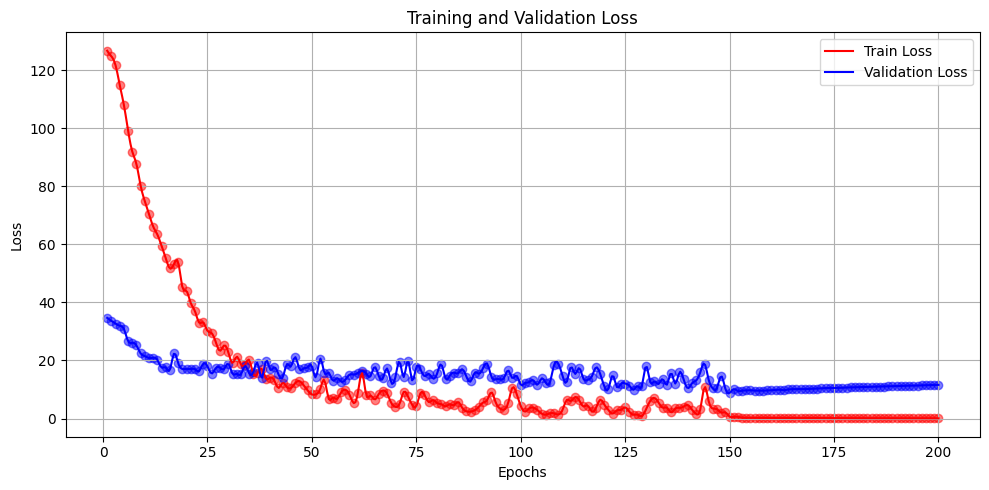

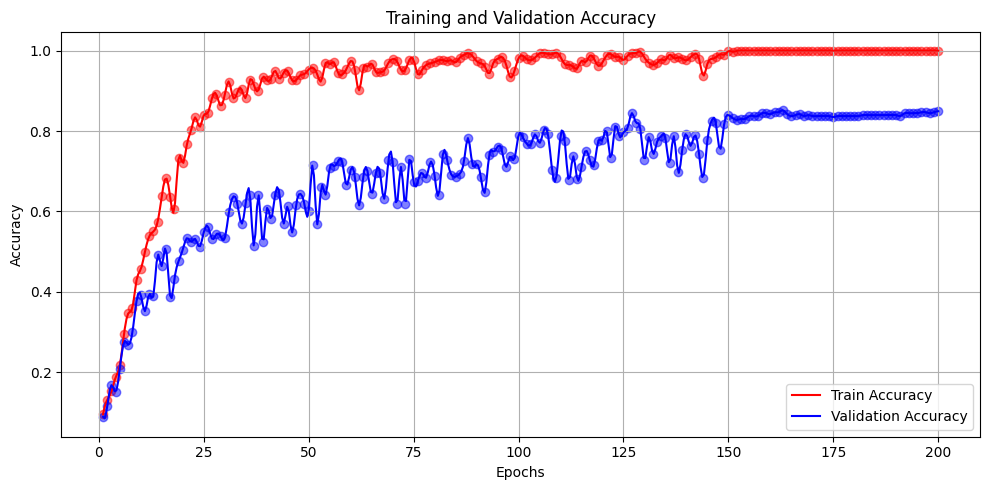

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from google.colab import drive

# Google Drive'ı bağla
drive.mount('/content/drive')

# 'metrics.pkl' dosyasını okuyun
def load_metrics(file_path):
    with open(file_path, "rb") as f:
        metrics_history = pickle.load(f)
    return metrics_history

def plot_metrics_from_file(metrics_history):
    # Epoch numaralarını alın
    epochs = [metrics["epoch"] for metrics in metrics_history]

    # Eğitim ve doğrulama kaybı ve doğruluğunu al
    train_losses = [metrics["train_loss"] for metrics in metrics_history]
    val_losses = [metrics["val_loss"] for metrics in metrics_history]
    train_accuracies = [metrics["train_accuracy"] for metrics in metrics_history]
    val_accuracies = [metrics["val_accuracy"] for metrics in metrics_history]

    # Daha sık aralıklarla epoch değerleri oluşturun
    epochs_new = np.linspace(min(epochs), max(epochs), 500)

    # Kaybı çizmek için spline interpolasyonu
    train_loss_spline = make_interp_spline(epochs, train_losses, k=3)
    train_loss_interpolated = train_loss_spline(epochs_new)

    val_loss_spline = make_interp_spline(epochs, val_losses, k=3)
    val_loss_interpolated = val_loss_spline(epochs_new)

    # Kaybı çiz
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_new, train_loss_interpolated, 'r', label='Train Loss')
    plt.plot(epochs_new, val_loss_interpolated, 'b', label='Validation Loss')
    plt.scatter(epochs, train_losses, color='r', alpha=0.5)
    plt.scatter(epochs, val_losses, color='b', alpha=0.5)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Grafiklerin sıkışıklığını azaltmak için
    plt.show()
    plt.close()

    # Doğruluğu çizmek için spline interpolasyonu
    train_acc_spline = make_interp_spline(epochs, train_accuracies, k=3)
    train_acc_interpolated = train_acc_spline(epochs_new)

    val_acc_spline = make_interp_spline(epochs, val_accuracies, k=3)
    val_acc_interpolated = val_acc_spline(epochs_new)

    # Doğruluğu çiz
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_new, train_acc_interpolated, 'r', label='Train Accuracy')
    plt.plot(epochs_new, val_acc_interpolated, 'b', label='Validation Accuracy')
    plt.scatter(epochs, train_accuracies, color='r', alpha=0.5)
    plt.scatter(epochs, val_accuracies, color='b', alpha=0.5)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Grafiklerin sıkışıklığını azaltmak için
    plt.show()
    plt.close()

# 'metrics.pkl' dosyasının bulunduğu yolu girin
metrics_file_path = "/content/drive/MyDrive/model/wav2vec/metrics.pkl"

# Metrics verilerini yükleyin
metrics_history = load_metrics(metrics_file_path)

# Grafikleri çizdirin
plot_metrics_from_file(metrics_history)
